In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from tqdm.auto import tqdm

In [2]:
from src.conditional_ngram_models import BigramSpellCorrector, TrigramSpellCorrector
from src.ngram_models import *

## The Dataset

In [3]:
nltk.download('movie_reviews')
nltk.download('gutenberg')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/dimits/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/dimits/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
movie_corpus = nltk.corpus.movie_reviews.fileids()                                 #Get all the files

In [5]:
gutenberg_corpus = nltk.corpus.gutenberg.fileids()                                 #Get all the files
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
filtered_gutenberg_corpus = [                        #We wish to keep only these from gutenberg corpus
    'austen-emma.txt', 
    'austen-persuasion.txt', 
    'austen-sense.txt', 
    'burgess-busterbrown.txt', 
    'carroll-alice.txt', 
    'chesterton-ball.txt',
    'chesterton-brown.txt' ]

In [7]:
combined_text = ""   

print("Loading Gutenberg corpus...")
for file_id in tqdm(filtered_gutenberg_corpus):                                        # Combine the text from all files
    combined_text += nltk.corpus.gutenberg.raw(file_id)

print("Loading Movie Review corpus...")
for file_id in tqdm(movie_corpus):
    combined_text += nltk.corpus.movie_reviews.raw(file_id)
    
print(combined_text[:500])

Loading Gutenberg corpus...


  0%|          | 0/7 [00:00<?, ?it/s]

Loading Movie Review corpus...


  0%|          | 0/2000 [00:00<?, ?it/s]

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


In [8]:
import re


def remove_special_chars(text):
    text = text.replace('[', '')
    text = text.replace(']', '')
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-zA-z.?!\']', ' ', text)                     #Remove these characters   

    return text

In [9]:
combined_text = remove_special_chars(combined_text)
combined_text[:500]

"Emma by Jane Austen       VOLUME I  CHAPTER I   Emma Woodhouse  handsome  clever  and rich  with a comfortable home and happy disposition  seemed to unite some of the best blessings of existence  and had lived nearly twenty one years in the world with very little to distress or vex her.  She was the youngest of the two daughters of a most affectionate  indulgent father  and had  in consequence of her sister's marriage  been mistress of his house from a very early period.  Her mother had died too"

In [10]:
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(''.join(text))                  #Get the sentences
    return sentences     

In [11]:
sentences = tokenize_sentences(combined_text) 
print(len(sentences))    
print(sentences[2])  
print(sentences[57649])

99864
Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses  and her place had been supplied by an excellent woman as governess  who had fallen little short of a mother in affection.
certain moments are so preposterous that i nearly herniated myself in an attempt to stifle laughter .


In [12]:
def tokenize_words(text):
    words = nltk.word_tokenize(text)
    return words

In [13]:
words = tokenize_words(combined_text)
print(len(words))
print(words[3])
print(words[-2])

2002260
Austen
be


In [14]:
words_list = []                                    #list of all the words of sentences
print("Getting words from source texts...")
for f in tqdm(sentences):
    words_list.append(tokenize_words(f))                   

Getting words from source texts...


  0%|          | 0/99864 [00:00<?, ?it/s]

In [15]:
for word in words_list[1]:                     # all the words of the second sentence
    print(word) 

She
was
the
youngest
of
the
two
daughters
of
a
most
affectionate
indulgent
father
and
had
in
consequence
of
her
sister
's
marriage
been
mistress
of
his
house
from
a
very
early
period
.


In [16]:
import random
import math


random.shuffle(words_list)
train_len = math.floor(0.6 * len(words_list))                      #Training set length(60%)
dev_len = math.floor(0.2 * len(words_list))                        #Development set length (20%)
test_len = math.floor(0.2 * len(words_list))                       #Test set length (20%)

training_set = []
development_set = []
test_set = []

for content in words_list[0:train_len]:
    training_set.append(content)
    
for content in words_list[train_len: train_len + dev_len]:
    development_set.append(content)

for content in words_list[train_len + dev_len:]:
    test_set.append(content)

In [17]:
import itertools
from collections import Counter

from nltk.util import ngrams


def _calc_ngrams(all_corpus: list[str], ngram: int) -> Counter:
    """
    Process a tokenized sentence into a list of ngrams.
    :param all_corpus: a list of all the corpus words
    :param ngram: whether the ngrams will be unigrams, bigrams etc
    :return: the counter of either unigram, bigram or trigram
    """
    unigram_counter = Counter()
    bigram_counter = Counter()
    trigram_counter = Counter()
     
    

    if ngram == 1 :
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             unigram_counter.update(grams)
        return unigram_counter
        
    elif ngram == 2:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             bigram_counter.update(grams)
        return bigram_counter
        
    elif ngram == 3:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             trigram_counter.update(grams)
        return trigram_counter
        
    return 0

In [18]:
def replace_OOV_words_train(all_corpus):
    unigram_counter = _calc_ngrams(all_corpus,1)
    OOV_words = {}

    for k, v in unigram_counter.items():
        if v < 10:
            key = k[0]
            # README: Use the symbol UNKOWN_TOKEN else the model will think it's a word
            OOV_words[key] = UNKNOWN_TOKEN                 #set the word to "UNK"

    replaced_corpus = []                          #the original corpus having the OOV words replaced by 'UNK'
    for sentence in all_corpus:
        clean_sentence = []
    
        for word in sentence:
            clean_sentence.append(OOV_words.get(word, word))
    
        replaced_corpus.append(clean_sentence)


    vocabulary = []

    for key in unigram_counter.keys():        #Iterate the unigram counter
        word = key[0]                         #get the word
        if word not in OOV_words:
            vocabulary.append(word)

    vocabulary = set(vocabulary)              #Keep unique words
    return vocabulary, replaced_corpus, OOV_words

In [19]:
def replace_OOV_words_test(all_corpus, vocabulary, oov_words):
    
    replaced_corpus = []
    for sentence in all_corpus:
        updated_sent = []

        for word in sentence:
            if (word not in vocabulary) or (word in oov_words):
                updated_sent.append(UNKNOWN_TOKEN)
            else:
                updated_sent.append(word)
                
    replaced_corpus.append(updated_sent)
    return replaced_corpus   

In [20]:
vocabulary, train_corpus, OOV_words = replace_OOV_words_train(training_set)
development_set = replace_OOV_words_test(development_set, vocabulary, OOV_words)
test_set = replace_OOV_words_test(test_set, vocabulary, OOV_words)

In [21]:
vocab_len = len(vocabulary)
print ("Vocabulary length: ", vocab_len)

print("Unigram's 20 most common words:")
unigram_top_20 = _calc_ngrams(train_corpus, 1).most_common(20)
for gram in unigram_top_20:
    print(gram)

print("\n")
print("Bigram's 20 most common words:")
bigram_top_20 = _calc_ngrams(train_corpus,2).most_common(20)
for gram in bigram_top_20:
    print(gram)


print("\n")
print("Trigram's 20 most common words:")
trigram_top_20 = _calc_ngrams(train_corpus,3).most_common(20)
for gram in trigram_top_20:
    print(gram)

Vocabulary length:  8269
Unigram's 20 most common words:
(('<UNK>',), 77972)
(('the',), 59389)
(('.',), 53527)
(('and',), 31288)
(('a',), 29811)
(('of',), 29775)
(('to',), 28701)
(('in',), 18127)
(('is',), 18032)
(('it',), 13841)
(('that',), 13490)
(("'s",), 12857)
(('as',), 9821)
(('with',), 9168)
(('he',), 8694)
(('for',), 8506)
(('his',), 8479)
(('was',), 8160)
(('but',), 7233)
(('be',), 6820)


Bigram's 20 most common words:
(('.', '<end>'), 53315)
(('<UNK>', '<UNK>'), 7846)
(('of', 'the'), 6904)
(('the', '<UNK>'), 6786)
(('<UNK>', '.'), 6622)
(('<UNK>', 'and'), 5102)
(('<start>', 'the'), 4940)
(('in', 'the'), 4680)
(('a', '<UNK>'), 3798)
(('?', '<end>'), 3560)
(('<start>', '<UNK>'), 3504)
(('and', '<UNK>'), 3419)
(('<UNK>', 'of'), 3305)
(('the', 'film'), 2804)
(('to', 'be'), 2676)
(('!', '<end>'), 2528)
(('of', '<UNK>'), 2441)
(('<UNK>', 'the'), 2370)
(('it', "'s"), 2336)
(('to', 'the'), 2326)


Trigram's 20 most common words:
(('.', '<end>', '<end>'), 53315)
(('<UNK>', '.', '<end

In [22]:
from nltk.tokenize import sent_tokenize, TweetTokenizer


UNK_sentences = [sent_tokenize(' '.join(sentence)) for sentence in train_corpus]       #get the sentences that include UNK values
tweet_wt = TweetTokenizer()
tokenized = [tweet_wt.tokenize(' '.join(sentence)) for sentence in UNK_sentences[:50]]  # Get the first 50 sentences

##  Calculate bi-gram probability

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

## Bi-gram LM Cross entropy & perplexity

* $ CrossEntropy = -\frac{1}{N}\sum^{bigrams}{log_2(P(w_2|w_1))} $
 * N: Number of bigrams
* $ Perplexity = 2^{H(p)} $

## Tri-gram LM Cross entropy & perplexity

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

In [23]:
def cross_entropy(model: BaseNgramModel, dataset: list[list[str]]) -> float:
    """
    Calculate the cross-entropy of a language model on a given dataset.
    
    Cross-entropy measures how well the language model predicts the given dataset.
    Lower cross-entropy indicates better model performance.
    
    :param model: The n-gram language model for which cross-entropy is calculated.
    :param dataset: The dataset as a list of tokenized sentences, where each sentence is a list of strings.
    :return: The cross-entropy score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    # since la place smoothing is only involved during inference
    # we don't need to refit the model
    sum_prob = 0
    word_count = 0
    
    for sentence in dataset:       
        # since this is a full sentence we manually append the end token
        sentence += [END_TOKEN]
        
        # take into account only the END_TOKEN since START token probs are not computed
        word_count += len(sentence)
        
        # get sentence probability
        sum_prob += bi_model.sentence_proba(sentence) 
    
    # do we need to logarithmize this again?
    return - sum_prob / word_count


def perplexity(cross_entropy: float) -> float:
    """
    Calculate perplexity from cross-entropy.
    
    Perplexity is a measure of how well the language model predicts the given dataset.
    A model with a perplexity of k, has approximately a 1/k chance of correctly predicting the next word in a sentence.
    
    :param cross_entropy: The cross-entropy score calculated for a language model on a dataset.
    :return: The perplexity score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    return 2**cross_entropy

In [24]:
def plot_alpha_vs_entropy(alpha_values, entropy, best_index):
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, entropy, marker='o', linestyle='-', color='b')
    plt.title('Alpha vs Entropy')
    plt.xlabel('Alpha Values')
    plt.ylabel('Cross Entropy')
    plt.grid(True)
    
    # Highlight the best alpha value
    plt.scatter(alpha_values[best_index], entropy[best_index], color='r', marker='x', label='Best Alpha')
    
    plt.legend()
    plt.show()

In [25]:
def ngram_model_alpha_search(fitted_model: BaseNgramModel, 
                             alpha_values: np.ndarray, 
                             validation_dataset: list[list[str]]) -> float:
    entropy_arr = np.full_like(alpha_values, np.inf)
    
    print("Beginning grid search for n-gram model...")
    for i in tqdm(range(len(alpha_values))):
        fitted_model.alpha = alpha_values[i]
        entropy_arr[i] = cross_entropy(fitted_model, validation_dataset)
        
       
    best_index = np.argmin(entropy_arr)
    plot_alpha_vs_entropy(alpha_values,entropy_arr, best_index) 
    return alpha_values[best_index]

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

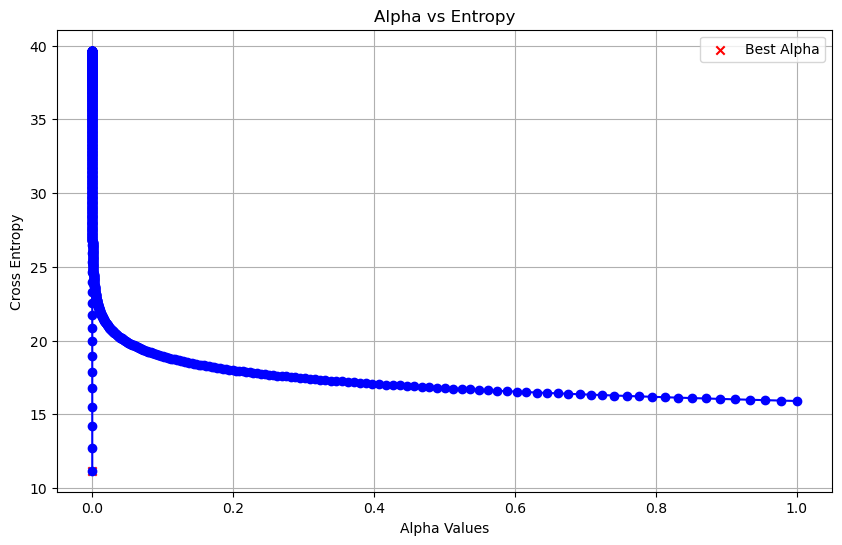

Optimal alpha (bigram model):  1e-10


In [26]:
bi_model = BigramModel(alpha=0.001)
bi_model.fit(train_corpus)

bi_opt_alpha = ngram_model_alpha_search(bi_model, np.logspace(-10, 0, 1000), development_set)
print("Optimal alpha (bigram model): ", bi_opt_alpha)

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

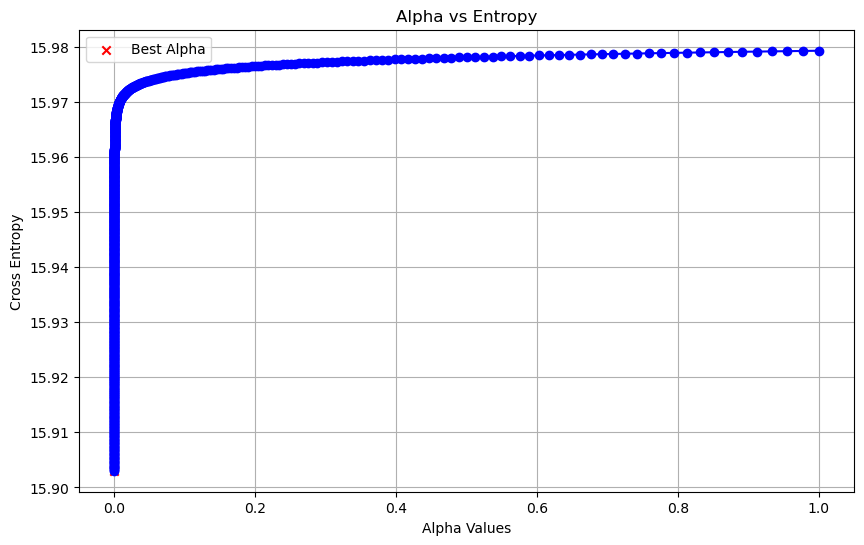

Optimal alpha (trigram model):  1e-10


In [27]:
tri_model = TrigramModel(alpha=0.001)
tri_model.fit(train_corpus)

tri_opt_alpha = ngram_model_alpha_search(tri_model, np.logspace(-10, 0, 1000), development_set)
print("Optimal alpha (trigram model): ", tri_opt_alpha)

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

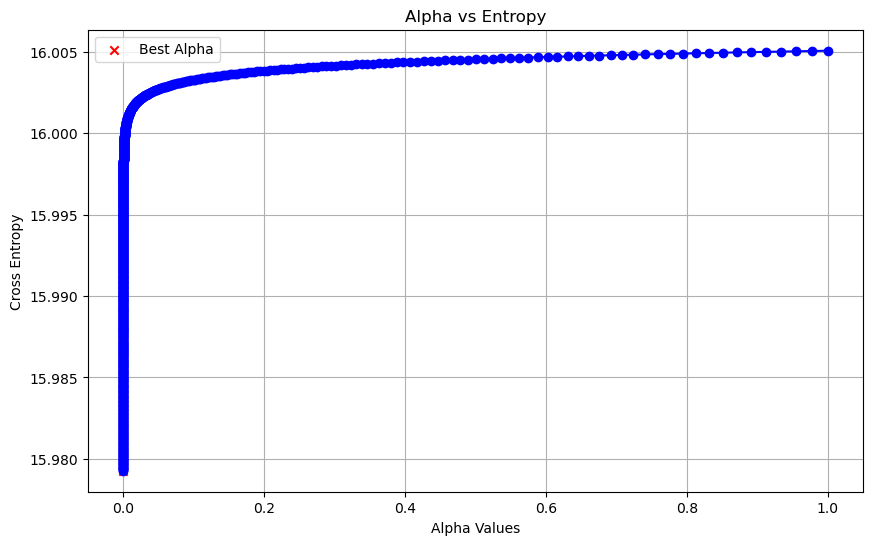

Optimal alpha (linear interpolation model):  1e-10


In [28]:
li_model = LinearInterpolationModel(alpha=0.01, lamda=0.5)
li_model.fit(train_corpus)
li_opt_alpha = ngram_model_alpha_search(li_model, np.logspace(-10, 0, 1000), development_set)

print("Optimal alpha (linear interpolation model): ", li_opt_alpha)

Now, let's test the performance in the test set, after having defined the optimal alpha.

In [29]:
# since la place smoothing is only involved during inference
# we don't need to refit the model
bi_model.alpha = bi_opt_alpha

bi_hc = cross_entropy(bi_model, test_set)
print(f"Bi-gram model Cross Entropy: {bi_hc:.2f}", )
print(f"Bi-gram model Perplexity: {perplexity(bi_hc):2f}")

Bi-gram model Cross Entropy: 15.45
Bi-gram model Perplexity: 44765.874632


In [30]:
tri_model.alpha = tri_opt_alpha

tri_hc = cross_entropy(tri_model, test_set)
print(f"Tri-gram model Cross Entropy: {tri_hc:.2f}")
print(f"Tri-gram model Perplexity: {perplexity(tri_hc):.2f}")

Tri-gram model Cross Entropy: 17.13
Tri-gram model Perplexity: 143640.72


v. Create a fake dataset

In [31]:
import random


def corrupt_sentence(sentence, probability):
    corrupted_sentence = ""
    for char in sentence:
        if char != ' ' and random.random() < probability:
            
            corrupted_sentence += get_similar_char(char)                 #replace with a similar character
        else:
            corrupted_sentence += char
    return corrupted_sentence


def get_similar_char(char):
    # later on maybe use the nlpaug library here 
    similar_chars = {
        'a': 'e',
        'b': 'p',
        'c': 's',
        'd': 'b',
        'e': 'a',
        'f': 't',
        'g': 'j',
        'h': 'n',
        'i': 'l',
        'j': 'g',
        'k': 'x',
        'l': 'i',
        'm': 'n',
        'n': 'm',
        'o': 'u',
        'p': 'b',
        'q': 'g',
        'r': 't',
        's': 'c',
        't': 'f',
        'u': 'o',
        'v': 'w',
        'w': 'v',
        'x': 'k',
        'y': 'v',
        'z': 's',
    }
    
    return similar_chars.get(char, char)                            #return a randomly chosen character

In [32]:
probability = 0.2                                        #probability of character replacement
#UNK_sentences = [sent for sent in UNK_sentences if len(sent) > 3]
corrupted_corpus = [[corrupt_sentence(word, probability) for word in sentence] for sentence in UNK_sentences]   #generate the corrupted corpus
corrupted_tokenized = [tweet_wt.tokenize(sentence) for sentence_list in corrupted_corpus for sentence in sentence_list] #tokenize the corrupted sentences

for original, corrupted in zip(UNK_sentences[:5], corrupted_corpus[:5]):
    print(f"Original: {original}")
    print(f"Corrupted: {corrupted}")
    print("\n---\n")

Original: ['the only single person i enjoyed was chris kattan because well he just <UNK> me up .']
Corrupted: ['tne umlv single parcom i emgoyed ves chric keftan because wall he jusf <UNK> me up .']

---

Original: ['as written by joe eszterhas .']
Corrupted: ['as wtiftem bv goe eszterhas .']

---

Original: ["hours later marie 's <UNK> a full scale search when jean has n't returned but no trace of him is found ."]
Corrupted: ["huurs later merie 's <UNK> a full scale searcn when jeam hac m't teturnad put no ftaca of him is founb ."]

---

Original: ['watch out for <UNK> <UNK> chaos in <UNK> hall and the <UNK> from <UNK> <UNK> <UNK> nose along with comic turns from molly shannon and chris elliot plus the voices of william <UNK> and brandy <UNK> .']
Corrupted: ['watsh out fut <UNK> <UNK> chauc in <UNK> hall end the <UNK> trom <UNK> <UNK> <UNK> nose along wlfh cumis turns fron molly shamnon and chric elliut plus fne voices of wiillam <UNK> and brandv <UNK> .']

---

Original: ['and as all

In [33]:
import jiwer


def calculate_wer_cer(original_sentences, corrected_sentences):
    wer_sum = 0
    cer_sum = 0
    total_sentences = len(original_sentences)

    for original, corrected in zip(original_sentences, corrected_sentences):
        wer = jiwer.wer(original, corrected)
        
        wer_sum += wer

        
        cer = jiwer.cer(original, corrected)
        cer_sum += cer

    
    avg_wer = wer_sum / total_sentences
    avg_cer = cer_sum / total_sentences

    return avg_wer, avg_cer

In [34]:
# how many sentences to be used for the spell correct models
to_correct_num = 15

In [35]:
bi_corrected = []
corrector = BigramSpellCorrector(bi_model, lamda=0.1)

print(f"Bigram model: Computing correct sentences for {to_correct_num} sentences")
for sent in tqdm(corrupted_tokenized[:to_correct_num]):
    output_seq = corrector.spell_correct(original_tokenized_sentence=sent, beam_width = 3)  #give the corrupt sentences to spell correct
    bi_corrected.append(output_seq)

# made one print so it is visualized better
print('Sample original sentence:', UNK_sentences[1])
print('\n')
print('Corrupted(wrong) sentence:', corrupted_corpus[1])
print('\n')
print('Final bi-gram result (corrected sentence):', " ".join(bi_corrected[1]))

Bigram model: Computing correct sentences for 10 sentences


  0%|          | 0/10 [00:00<?, ?it/s]

Sample original sentence: ['watch out for <UNK> <UNK> chaos in <UNK> hall and the <UNK> from <UNK> <UNK> <UNK> nose along with comic turns from molly shannon and chris elliot plus the voices of william <UNK> and brandy <UNK> .']


Corrupted(wrong) sentence: ['watsh out fut <UNK> <UNK> chauc in <UNK> hall end the <UNK> trom <UNK> <UNK> <UNK> nose along wlfh cumis turns fron molly shamnon and chric elliut plus fne voices of wiillam <UNK> and brandv <UNK> .']


Final bi-gram result (corrected sentence): as written by joe eszterhas .


In [36]:
avg_wer, avg_cer = calculate_wer_cer(tokenized[:to_correct_num], bi_corrected)

print(f"Bigram Average Word Error Rate (WER): {avg_wer:.3f}")
print(f"Bigram Average Character Error Rate (CER): {avg_cer:.3f}")

Bigram Average Word Error Rate (WER): 0.324
Bigram Average Character Error Rate (CER): 0.267


In [ ]:
tri_corrected = []
corrector = TrigramSpellCorrector(tri_model, lamda=0.1)

print(f"Trigram model: Computing correct sentences for {to_correct_num} sentences")
for sent in tqdm(corrupted_tokenized[:to_correct_num]):
    output_seq = corrector.spell_correct(original_tokenized_sentence=sent, beam_width = 3)  #give the corrupt sentences to spell correct
    tri_corrected.append(output_seq)
    
print('Sample original sentence:', UNK_sentences[0])
print('\n')
print('Corrupted(wrong) sentence:', corrupted_corpus[0])
print('\n')
print('Final tri-gram result (corrected sentences):', " ".join(tri_corrected[0]))

Trigram model: Computing correct sentences for 10 sentences


  0%|          | 0/10 [00:00<?, ?it/s]

Sample original sentence: ['the only single person i enjoyed was chris kattan because well he just <UNK> me up .']


Corrupted(wrong) sentence: ['tne umlv single parcom i emgoyed ves chric keftan because wall he jusf <UNK> me up .']


Final tri-gram result (corrected sentences): the mile in length i thought why liam neeson stars as the jury and the u .


In [ ]:
avg_wer, avg_cer = calculate_wer_cer(tokenized, tri_corrected)

# im looking into this
print(f"Trigram Average Word Error Rate (WER): {avg_wer}")
print(f"Trigram Average Character Error Rate (CER): {avg_cer}")

Trigram Average Word Error Rate (WER): 0.11392933054537913
Trigram Average Character Error Rate (CER): 0.10712634665183669
